### Diffusion notes - 02/18/24

A mildly interesting description of diffusion models given by GPT-4:

In the context of machine learning, diffusion models refer to a class of probabilistic models that generate new samples through a dynamic, iterative process. They start with a simple distribution, often a Gaussian, that gradually "diffuses" into a more complex one through a series of steps.

Initially introduced for unsupervised learning, diffusion models have gained popularity in generative modeling, especially for tasks like image and speech synthesis. They can iteratively refine an initial random sample into a sample that appears as if it is drawn from the data distribution.

In image generation, they represent an alternative to Generative Adversarial Networks (GANs) and Variational Autoencoders (VAEs). Diffusion models can generate distinctive images with state-of-the-art fidelity and variety, surpassing GANs in certain cases.

A significant advantage of diffusion models is their simplicity and theoretical elegance, as they involve a straightforward training process with a clearly defined objective function, unlike the often unstable adversarial training process of GANs and the approximate inference used in VAEs.

### Notes from Youtube video 'What are Diffusion Models?' 

If we added gaussian noise to the image below, it would eventually become indecipherable static. Diffusion models allow us to revert the image back to something useful or interesting.

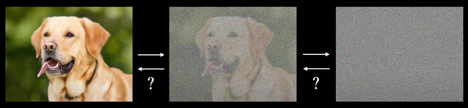

Denote an image $x_0$ and $x_T$ as the noisy static image. The map $x_0 \rightarrow x_1 \rightarrow \dots \rightarrow x_T$ is a markov chain that we can call 

$q(x_{1:T}|x_0) = \prod_{t=1}^T\limits q(x_1|x_{t-1})$

Where each step only depends on the previous state.


##### Forward

Each step is a diagonal gaussion defined as ~ $\mathcal{N}(x_t; \sqrt{1-\beta_t}x_{t-1}, \beta_tI)$ where I is the indentity matrix providing the diagonal nature and $\beta$ is the variance at time t. This variance increases with time during training but is bound $\beta \in (1,0)$. as $x_T$ approaches infinity, $q(x_T|x_0) \approx \mathcal{N}(0, I)$. We use a small step size and in practice steps T is in the order of 1000

##### Backwards

Diffusion models use the observation that in the limit of infintesimal step size, the true reverse process will have the same form as the forward. This means we can also model and define the reverse step as a Unimodal, diagonal Gaussian while also using time t.

$p_\theta (x_{t-1}|x_0) := \mathcal{N}(x_{t-1}; \mu_\theta(x_t, t), \Sigma_\theta(x_t, t))$

$x_0 \leftarrow \dots \leftarrow x_{T-1} \leftarrow x_T$

$p_\theta(x_{0:T}) := p(x_T) \prod_{t=1}^T\limits p_\theta(x_{t-1}|x_t)$

so we can write this reverse process markov chain (above) as a joint probability of the product of conditional probabilities and marginal probability of $x_T$

Where $p(x_T)$ is the same as q from the forward process:  ~ $\mathcal{N}(x_T;0,I)$

This means that at inference time, we start from a gaussian (static looking) image $x_T$ and make our way back to $x_1$ using our learned parameters.

##### Objective optimization

We can't directly calculate the probability of $x_0$ by $p_\theta(x_0) = \int p_\theta(x_{0:T})dx_{1:T}$ because we would have to calculate all possible paths from 0 to T which would be intractible.

but what we can do, is calculate a lower bound.

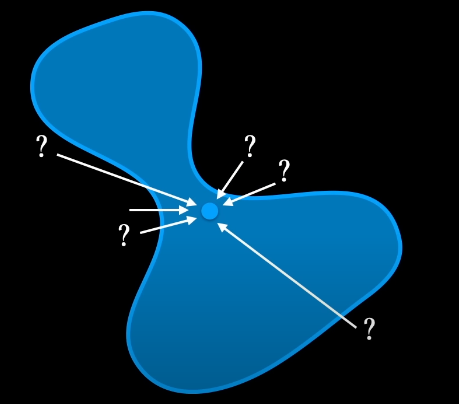

A useful trick is to view $x_0$ as an observed variable and $x_{1:T}$ as latent variable. Similarly in other transormer model/architectures, this can be seen as a latent variable generative model. These models use encoders and decoders to deal with these latent variables.

If we have observed variable x and latent variables z we can establish a variational lower bound that is less than or equal to the marginal log likeliood 

$\log p_\theta(x) \geq $ variational lower bound

where the v.l.b. := $\mathbb{E}_{q(z|x)}[\log p_\theta(x|z)] - D_{KL}(q(z|x) || p_\theta(z))$

The first term is a likelihood term which encourages the model to maximize the expected density assigned to the data

The second is a KL Divergence term which encourages the approx and posterior $q(z|x)$ to be similar to the prior on the latent variable $p_\theta(z)$

We can rewrite this using our $x_0$ observed and $x_{1:T}$ latent variables

$\log p_\theta(x_0) \geq \mathbb{E}_{q(x_{1:T}|x_0)}[\log p_\theta(x_0|x_{1:T})] - D_{KL}(q(x_{1:T}|x_0) || p_\theta(x_{1:T}))$

This KL Divergence can be expanded to include both terms in a single expectation

$$
\begin{split}
\log p_\theta(x_0) \geq \ &
      \mathbb{E}_{q(x_{1:T}|x_0)}[\log p_\theta(x_0|x_{1:T})] - D_{KL}(q(x_{1:T}|x_0) || p_\theta(x_{1:T})) \\
    \geq \space &
      \mathbb{E}_q[\log p_\theta(x_0|x_{1:T})] -  \mathbb{E}_q\Big[\log \frac{q(x_{1:T}|x_0)}{p_\theta(x_{1:T})}\Big]\\
    \geq \space &
      \mathbb{E}_q\Big[\log p_\theta(x_0|x_{1:T}) + \log \frac{p_\theta(x_{1:T})}{q(x_{1:T}|x_0)}\Big]\\
    \geq \space &
      \mathbb{E}_q\Big[ \log \frac{p_\theta(x_{0:T})}{q(x_{1:T}|x_0)}\Big]\\
\end{split}
$$

Then we can rewrite this final result by refactoring the chain probabilities into their indiviudal steps.

$\mathbb{E}_q \Big[\log p(x_T) + \sum_{t\geq1}\limits \log \frac{p_\theta(x_{t-1}|x_t)}{q(x_t|x_{t-1})}\Big]$